# Определение стоимости автомобилей

<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Нияз! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Основные шаги:

1) Загрузите данные, путь к файлу: /datasets/autos.csv.

2) Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.

3) Подготовьте выборки для обучения моделей.

4) Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

5) Проанализируйте время обучения, время предсказания и качество моделей.

6) Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

## Подготовка данных

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

### Скачаем датасет и посмотрим на него

In [2]:
df = pd.read_csv("/datasets/autos.csv")

    

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>


Совет 🤔:
    
    
-  есть такой интересный аргумент при чтении как  parse_dates - позволяет указать какие столбцы в DataFrame содержат даты и время. Если у нас установлен верный тип данных, это значит что мы можем легко вытасиквать информацию о годе, месяце, дня, времени, можем вычитать, прибавлять из столбца с датами другой столбец с датами, получая осмысленную информацию
    
    


    
    



In [3]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Проверка на дубликаты

In [4]:
print(df.duplicated().sum())

4


Удаляем

In [5]:
df = df.drop_duplicates().reset_index(drop=True)
print(df.duplicated().sum())

0


### Удалим неинформативные столбцы

In [6]:
df = df.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

Я решил удалить следующие столбцы по той причине, что они не несут никакой информации непосредственно о автомобиле. А так как мы хотим предсказать "нетто" стоимость машины, думаю эти столбцы нам не понадобятся.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:


Если данные не представляют интересы для модели то почему бы их и не убрать
    

    
<div class="alert alert-warning">



Совет 🤔:    

- по почтовому индексу можно определить страну где автомобиль скорее всего эксплуатировался. Это конечно потребует сбора информации, но возможно если мы более 8000 индексов превратим в конкретный перечень двух десятков стран, модель сможет на этом найти что то интересное, хотя это не точно )    

    

### Посмотрим на данные, найдём пропуски

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:





для лучшего контроля лучше импортны собирать в одном месте

<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>

Исправлено

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



👍



Привет Нияз


In [7]:
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650
std,4514.176349,90.228466,189.851330,37905.083858,3.726432
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


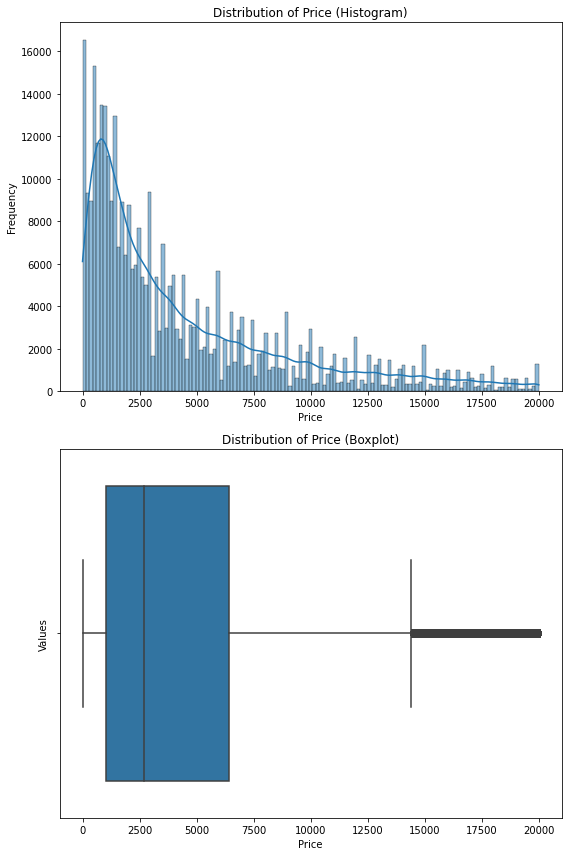

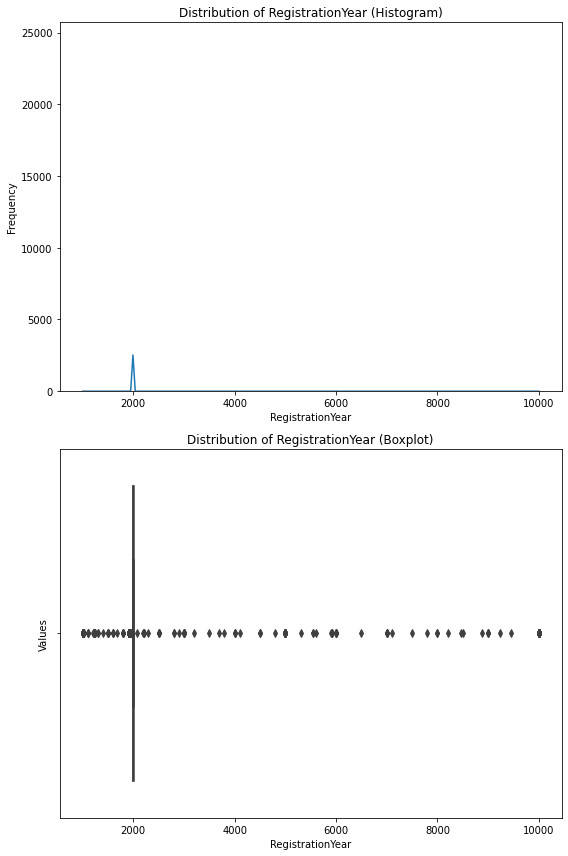

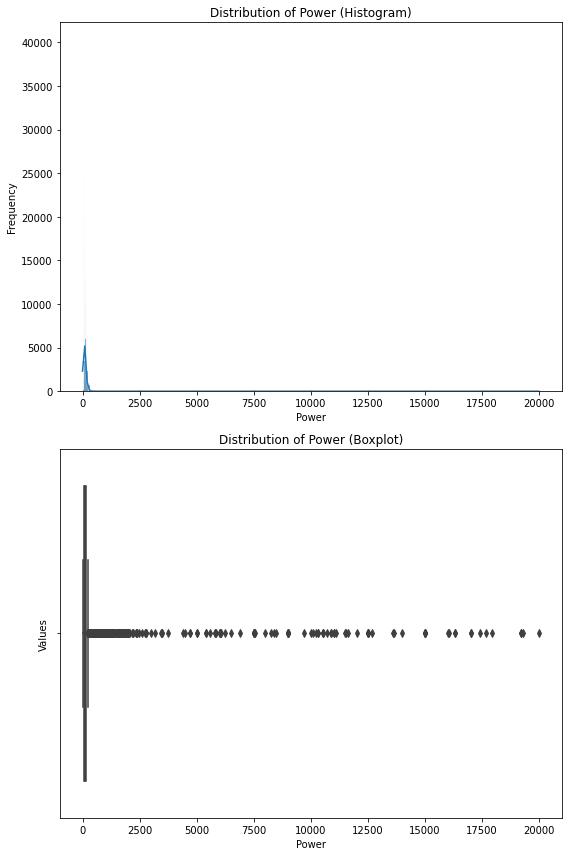

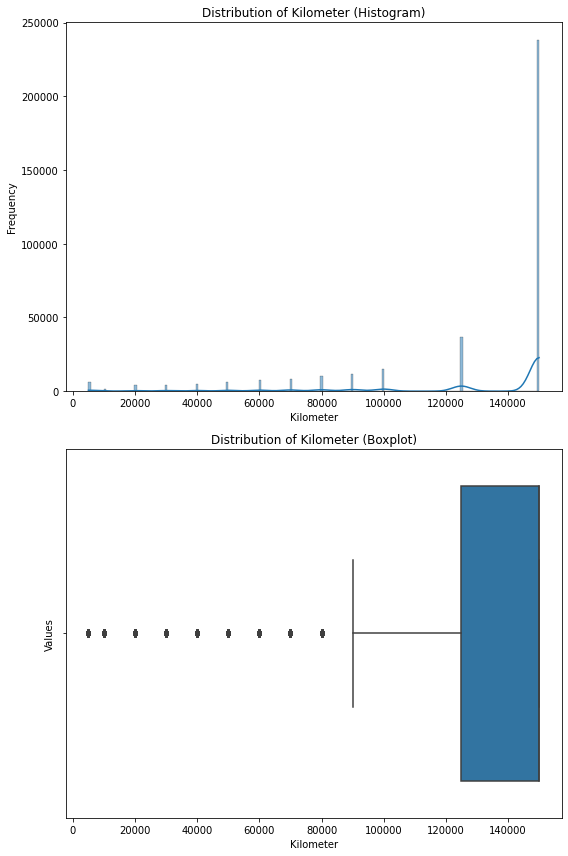

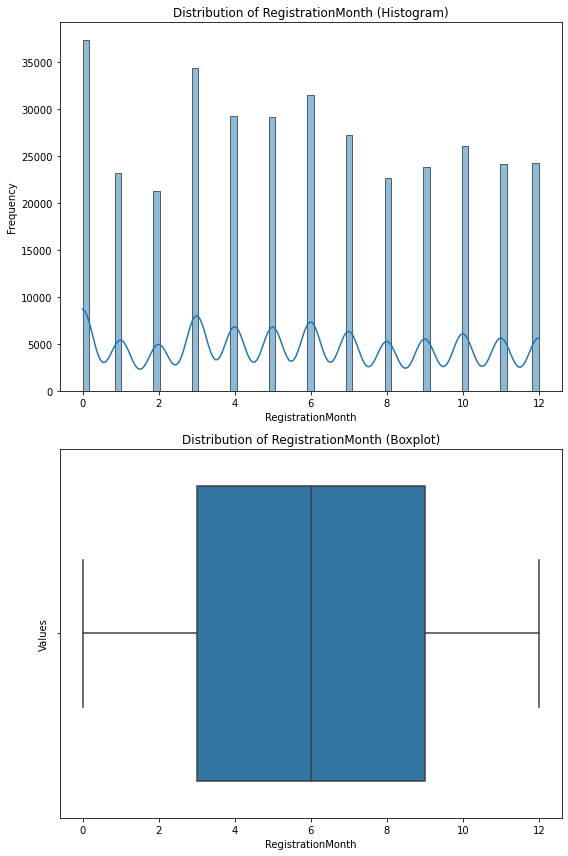

In [8]:
digital = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
for column in digital:
    fig, axes = plt.subplots(2, 1, figsize=(8, 12))

    sns.histplot(df[column], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {column} (Histogram)')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    sns.boxplot(x=df[column], ax=axes[1])
    axes[1].set_title(f'Distribution of {column} (Boxplot)')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Values')

    plt.tight_layout()
    plt.show()

Данные выглядят ну очень интересно. Необходимо разобраться с нулевой стоимостью авто, нулевой мощностью, годом, а так же пробегом в 150тыс. Также видем, что у нас 13 месяцев вместо 12.

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:





В выводу не хватает о том что месяцев 12 а не 13
    
    
<div class="alert alert-warning">
 

Совет 🤔:



 

- Можно было построить графики для категориальных    (pie, count)bm

    
    
    
- Кстати для числовых признаков лучше одновременно строить график типа hist и boxplot. Гистограмма - позволяет нам увидеть, как данные распределены.  Boxplot  помогает нам понять разброс данных и выявить аномалии. И  можно красиво разместить их с помощью subplots - в одном столбце строим гистограмму ждля признака, в другом boxplot.  И если ты это сделаешь, то конечно лучше сразу оформить в виде функции, чтобы можно было использовать в следующих проектах (в качестве аргументов подаём dataset и названия столбцов с количественными признаками)


    

<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>

Исправлено. Не знаю, как поступить с 0 месяцем.

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:



Это сложный вопрос, тут  разные варианты,  но хотя хотя бы стоило обратить на эту некоректность внимание, это сделано


In [9]:
print(df['Price'].value_counts())

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64


менее 10% данных, удалим их

In [10]:
df = df.loc[df['Price'] > 0]

In [11]:
print(df['Power'].value_counts())

0        36360
75       23319
60       15465
150      14170
101      12960
         ...  
923          1
10910        1
4400         1
1689         1
6006         1
Name: Power, Length: 701, dtype: int64


более 10%, необходимо обработать

In [12]:
df = df.loc[df['Power'] <= 1300]
df['Power'] = df['Power'].replace(0, df['Power'].median())

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Поработал с аномалиями,  обратил внимание на количество данных которые мы потеряем если дропнуть


Посмотрим на года производства автомобилей

In [13]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1959, 1956,
       3200, 1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957,
       1940, 3000, 2066, 1949, 2019, 1937, 1951, 1953, 1954, 1234, 8000,
       5300, 9000, 2900, 6000, 5900, 5911, 1950, 4000, 1948, 1952, 8500,
       1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 6500,
       1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934, 1938, 1928,
       1800, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

Думаю не стоит брать во внимание авто ранее 1980 годов, так как они врядли попадают под понятие "автомобиль", скорее "раритетный экспонат". Очевидно авто после 24 года выпуска ещё нет.

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:

 



По поводу лет - стоит обратить внимание что верхняя граница — 2016 год - год выгрузки базы. Если есть строчка с больше 2016, то это явно ошиибка заполнения, такое лучше убрать


<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>

Исправлено

In [14]:
df = df.loc[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] >= 1980)]
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007,
       2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006, 1999,
       2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982, 1983,
       1987, 1986, 1988, 1980])

Я не знаю, что делать со столбцом Kilometer. Нужен ли он, когда большая часть данных находится в окресности 150 тысяч?

In [15]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326446 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              326446 non-null  int64  
 1   VehicleType        306778 non-null  object 
 2   RegistrationYear   326446 non-null  int64  
 3   Gearbox            311400 non-null  object 
 4   Power              326446 non-null  float64
 5   Model              311557 non-null  object 
 6   Kilometer          326446 non-null  int64  
 7   RegistrationMonth  326446 non-null  int64  
 8   FuelType           302851 non-null  object 
 9   Brand              326446 non-null  object 
 10  Repaired           267526 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 29.9+ MB


None

Есть пропуски в столбцах VehicleType, Gearbox, Model, FuelType и Repaired. Столбец Repaired имеет больше всего пропусков, но я считаю, что данные пропуски связаны с тем, что пользователи приложения не указывали этот параметр, т.к. машина не находилась в ремонте (не посчитали важным). Остальные столбцы предлагаю заполнить наиболее частыми значениями.

### Восполнение пропусков при помощи SimpleImputer

Выделим необходимые столбцы и решим задачу

In [16]:
cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

imputer = SimpleImputer(strategy='most_frequent').fit(df[cat])
df[cat] = imputer.transform(df[cat])

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>


Совет 🤔:   
    
    

    


   
    
    
    
- по логике моделирования мы имеем информацию только о тренировочной выборке, поэтому если делать всё правильно, то мы сначала делаем сплит, затем применяем твою логику заполнение на тренировочной выборке, а затем используем ее на валидационной и тестовой выборке (тут аналогия с Scaler, когда мы делаем .fit на тренировочный  а потом .transform на валидационной\тестовой). А так как ты используешь GridSearch, то стоит еще логику заполнения пропусков засунуть в pipeline. 
    
    
Прелесть в том что   SimpleImputer отлично взаимодействует с pipeline

Проверим, ничего ли не сломалось

In [17]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326446 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              326446 non-null  int64  
 1   VehicleType        326446 non-null  object 
 2   RegistrationYear   326446 non-null  int64  
 3   Gearbox            326446 non-null  object 
 4   Power              326446 non-null  float64
 5   Model              326446 non-null  object 
 6   Kilometer          326446 non-null  int64  
 7   RegistrationMonth  326446 non-null  int64  
 8   FuelType           326446 non-null  object 
 9   Brand              326446 non-null  object 
 10  Repaired           326446 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 29.9+ MB


None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,sedan,1993,manual,105.0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,golf,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:



- Советую проверку на дубликаты сделать до удаления неинформативных столбцов. А так скорее всего в качестве дубликатов ты воспринял разные варианты, совпадающие по оставшися признакам. Как по-твоему может быть такое? И Почему не стоит удалять разные заявки но с совпадающими данными?
    

<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>
Думаю это связано с тем, что объявление было выложено повторно, но например через некоторое время, либо в другом месте. Учитывая, что данных много, а пробег видимо дискретный, то есть шанс совпадения объектов, наверное поэтому удалять не стоит.
Исправлено.

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:



если бы это было те же самые объявления но выложенные повторно, это  как раз  и были бы дубликаты. А вот если это разные варианты, то удалять не нужно, потому что на реальных данных скорее всего повторится те же частые комбинации, и стоит обучить модель чтобы они хорошо предсказывали именно частые случаи


In [18]:
cat.append('Brand')
for i in cat:
    print(df[i].unique())

['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto']
['golf' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'kangoo' 'one'
 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'fiesta'
 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe'
 'scenic' 'a4' 'ka' 'a1' 'insignia' 'combo' 'focus' 'tt' 'corsa' 'a6'
 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sorento' 'v40'
 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera' 'megane' 'lupo'
 'r19' 'caddy' 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo'
 'tiguan' 'sharan' '6_reihe' 'c4' 'panda' 'up' 'i_reihe' 'ceed' '5_reihe'
 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe' '6er' 'modus' 'fox' 'matiz'
 'beetle' 'c1' 'rio' 'touareg' 'logan' 'spider' 'cuore' 's_max' 'a2'
 'galaxy' 'c3' 'viano' 's_klasse' '1_reihe' 'avensis' 'roomster' 

In [19]:
df['FuelType'] = df['FuelType'].replace('petrol', 'gasoline')

### Микровывод:

В результате предобработки было выполнено следующее:

1) Осмотрены данные, выведены графики, описывающие числовые признаки

2) Удалены либо исправлены аномалии

3) Восполнены пропуски

4) Удалены полные дубликаты

5) Удалены неинформативные признаки

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:

 
    
На что ещё я бы обратил внимание
    

- 'petrol' и 'gasoline', ведь это   название одного и того же в разных странах. А у тебя получается это разное, и модель для работы получит некорректные представления   





- ниже ты используешь линейную модель. В этом случае рекомендуется провести предварительную проверку на  мультиколлинеарность, а еще было бы интересно посомтреть на корреляцию признаков и таргета (Не забываем об особенностях применения коеффициента Пирсона и Спирмена)



 


<div class="alert alert-warning">


Совет 🤔:





- работа пропусками тема очень тонкая, ведь в любом случае будет происходить искажение данных, каждый новый датасетом скорее всего надо будет требовать какой-то свой уникальный способ работы с пропусками, а как именно - это придёт с опытом. Тут можешь посмотреть какие вообще способы и подходы можно использовать  [первая часть](https://www.dmitrymakarov.ru/data-analysis/nan-06/) ,   [вторая часть](https://www.dmitrymakarov.ru/data-analysis/nan-06-2/) 

<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>
    
Исправлено. Выбрал Спирмена, так как он показывает силу зависимости и лучше работает не с нормальным распределением.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



👍




</div>


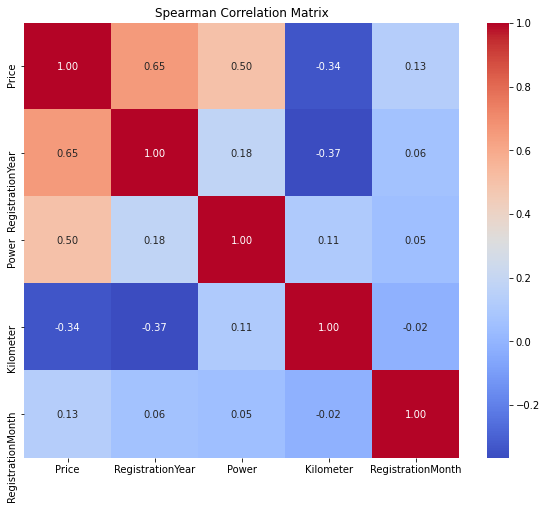

In [20]:
spearman_corr_matrix = df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Spearman Correlation Matrix')
plt.show()

Видна положительная корреляция между годом выпуска, мощностью модели и стоимостью (очевидно), однако я не вижу в этом проблемы. Так же чем меньше пробега, тем выше цена, но корреляция не сильная.

## Обучение моделей

### Подготовим наш датафрейм, для начала закодируем категориальные столбцы

In [21]:
data_ohe = pd.get_dummies(df, drop_first=True)
display(data_ohe.head())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
0,480,1993,105.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,2011,190.0,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75.0,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69.0,90000,7,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:


избежал  dummy trap




<div class="alert alert-warning">




Совет 🤔:


В тренажёре  .get_dummies и он вполне рабочий инстурмент, но для машинного обучения и на будущее (с прицелом на дальнейшее использование pipeline) присмотрись к OHE.  Почему OHE лучше можно почитать [тут](
https://albertum.medium.com/preprocessing-onehotencoder-vs-pandas-get-dummies-3de1f3d77dcc), а [с кодами тут](https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing#scrollTo=organized-pierce) 


Главная идея при использовании OHE -  кодирование до деления на выборки (test/train) приводит к ошибкам, поэтому используем OHE после train_test_split. Как в случаи с тем же  StandardScaler делаем .fit_transform на train,  .transform на test/valid    

    
    
В общем я бы тебе Настоятельно рекомендовал использовать OHE
    
 

### Разделим датафрейм на обучающий и тестовый

In [22]:
target_ohe = data_ohe['Price']
features_ohe = data_ohe.drop('Price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target_ohe, 
                                                                                            test_size=0.3, random_state=12345)
# Проверим размеры
print(features_train_ohe.shape)
print(features_test_ohe.shape)

(228512, 304)
(97934, 304)


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

 

- правильно разбито на 2 выборки (иногда студенты использующие GS разбивают на 3 датасета)




### Нормируем значения числовых признаков

Применим StandardScaler, fit делаем на трейне

In [23]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

/tmp/ipykernel_172/3730863481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_172/3730863481.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:






Можно объединить 2 логики работы с данными (Одна логика - это работа с количественными, вторая логика - это работа с категориальными) в одну с помощью ColumnTransformer

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])


Вот статьи про Сolumntransformer (и pipeline, потому что это темы связанны их лучше использовать одновременно)

1. https://medium.com/mlearning-ai/neat-data-preprocessing-with-pipeline-and-columntransformer-2a0468865b6b
2. https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156
3. вот статья про Pipeline и GridSearchCV - https://towardsdatascience.com/an-introduction-to-building-pipelines-and-using-grid-searches-in-scikit-learn-92ea72f9b5b7

 

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:



И уточню почему желателен   pipeline когда используешь GS, своими словами: 
    
Когда мы используем вручную прописанный цикл для поиска гиперпарамтеров, и разбиваем на три датасета, то мы же делаем так:
    


    scaler = StandardScaler()
    scaler.fit(train_feat[numeric])


    feat_train[numeric] = scaler.transform(feat_train[numeric])
    feat_test[numeric] = scaler.transform(feat_test[numeric])
    feat_valid[numeric] = scaler.transform(feat_valid[numeric])
    
    
    
То есть мы делаем   .fit на train, а на valid и test делаем   .transform, то есть когда мы обучаем наш StandardScaler,  мы используем только тренировочный датасет, а затем "распростроняем" выученное шкалирование на test/valid.  Нет подглядывания:   Мы не используем информацию из тестового и валидационного датасета, для того чтобы обучить StandardScaler(). В этом и смысл моделирования - мы как будто бы знаем только train, а тестового для нас как бы не существует.  Если мы при шкалировании начинаем использовать информацию из теста мы поступаем нечестно. 

    
    
А когда используем GridSearch
    
    
Вот твой код (условно)    
    
    scaler = StandardScaler()
    scaler.fit(train_feat)
    feat_train = scaler.transform(feat_train)    
    
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters)
    clf.fit(feat_train, target)
    
    
    
Обрати внимание - ты подал  feat_train, из  которого   GridSearchCV сам создаст valid и train и построит циклы. И вот тут оказывается что валидационный датасет у нас с подглядыванием, потому что на всем feat_train был сделан fit.  Вот в чём заключается подглядывание.  И раз GS делает валидационные внутри себя, спрашивается как добраться до нее и избежать подглядывания в будущее? Казалось бы никак, но нет! Pipeline! ) 
    
    
  
    
И вот как надо сделать pipeline чтобы не было утечки данных при шкалировании.  Как видишь кода немного 
    
    pipe = Pipeline([
            ('scale', StandardScaler(random_state = 42)),
            ('clf', SVC(kernel = 'linear', C = 1))])

    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

    clf = GridSearchCV(pipe, parameters)
    clf.fit(feat_train, target)
    
    
И теперь    feat_train будет разбит на train и valid, но .fit будет на train, а на valid будет .transform. Такй вот хитрый pipeline - он суёт свои ручки внутрь GS и делай так чтобы не было утечки данных.
    
    
    
    
    


</div>


Посмотрим, что же получилось:

In [24]:
features_train_ohe.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
233055,0.512854,1.001000,0.576605,0.046658,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
253460,0.015194,-1.108458,-0.097106,1.406077,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
261050,0.346967,-0.063063,-0.097106,1.134193,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
305894,-0.482466,-0.828441,0.576605,0.590426,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14928,-1.809559,-1.164461,-0.097106,-0.768994,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Приступим к обучению моделей:

Предлагаю рассмотреть линейную регрессию (признаки под неё уже закодированы), случайный лес, а также бустинг.

#### Линейная регрессия в деле:

In [25]:
%%time

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

lr_gs = GridSearchCV(
    estimator=LinearRegression(), 
    cv=3, 
    scoring='neg_root_mean_squared_error',
    param_grid=parameters
)

lr_gs.fit(features_train_ohe, target_train_ohe)

display(lr_gs.best_params_)
display(lr_gs.best_score_ * -1)


{'fit_intercept': True, 'normalize': False}

2623.065971221945

CPU times: user 2min 24s, sys: 55.3 s, total: 3min 19s
Wall time: 3min 19s


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:





Нас не интересует Метрика на тренировочной выборке (Кстати почему?),  тут тебя либо тоже надо использовать GridSearchCV и смотреть best_score_, либо создать ручную валидационную выборку, и посмотреть метрику по ней
    
 <div class="alert alert-warning">
 


Совет 🤔:


И хотелось бы понять почему ты не делаешь подборки параметров для линейной модели. Стоит этот момент объяснить


<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>
    
Исправлено. Не делал подбора по сетке, так как мало гиперпараметров для перебора.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



👍

#### Кодировка признаков Ordinal Encoder'ом для леса:

In [26]:
enc = OrdinalEncoder()
df[cat] = enc.fit_transform(df[cat])

target_oe = df['Price']
features_oe = df.drop('Price', axis=1)
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe, target_oe, 
                                                                                        test_size=0.3, random_state=12345) 

display(features_train_oe)
print(features_train_oe.shape)
print(features_test_oe.shape)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
233055,4.0,2006,1.0,173.0,11.0,150000,6,2.0,2.0,0.0
253460,5.0,2003,1.0,60.0,176.0,125000,11,2.0,9.0,0.0
261050,4.0,2005,1.0,116.0,6.0,125000,10,2.0,2.0,0.0
305894,7.0,2000,1.0,75.0,116.0,150000,8,2.0,38.0,0.0
14928,0.0,1992,1.0,57.0,222.0,125000,3,2.0,38.0,0.0
...,...,...,...,...,...,...,...,...,...,...
172403,4.0,2006,1.0,101.0,103.0,150000,9,2.0,10.0,0.0
51980,4.0,1999,1.0,55.0,116.0,150000,3,2.0,38.0,0.0
93684,5.0,1997,1.0,75.0,116.0,150000,4,2.0,38.0,0.0
83792,7.0,2005,0.0,225.0,116.0,150000,8,2.0,1.0,0.0


(228512, 10)
(97934, 10)



<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

    
- Верно, что в случае использования линейной модели категориальные признаки кодированы с помощью OHE/get_dummies
    
- Правильно, что  для  "деревянных" моделей  OrdinalEncoder    


<div class="alert alert-warning">
 


Совет 🤔:


 

    
- Можешь объяснить почему для линейных модели технику `OrdinalEncoder()` использовать нельзя, а для  деревянных моделей это не вызывает тех же проблем?
    
<div class="alert alert-info">
 


Ответ:
- Линейная модель может посчитать некоторые объекты более значимыми


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:

    
    
Я бы объяснил по-другому, если ты применишь к моделям  OE, то для компьютера  Mercedes  окажется больше чем Volvo, и в три раза больше чем Камаз (условно). Нелогично. Но если ты подаёшь результаты OE в модели на основе деревьев (Случайный лес,  Дерево решений), то это не так страшно, в силу того что модели делают сплиты, они нелинейные, поэтому могут подстроиться.  А вот если ты это подашь в линейные модели, то скорее всего получится проблема, потому что  линейная модель, будет стараться построить линию (гиперплоскость) в которой камаз > мерседес > вольво 

#### Обучим лес:

In [27]:
"""
%%time

parameters = {'max_depth': list(range(1, 10)),
              'n_estimators': [100, 500, 1000]
              }

dtr_gs = GridSearchCV(estimator=RandomForestRegressor(), 
                         cv=3, 
                         scoring='neg_root_mean_squared_error',
                         param_grid=parameters)

dtr_gs.fit(features_train_oe, target_train_oe)


display(dtr_gs.best_params_)
display(dtr_gs.best_score_ * -1)
"""

"\n%%time\n\nparameters = {'max_depth': list(range(1, 10)),\n              'n_estimators': [100, 500, 1000]\n              }\n\ndtr_gs = GridSearchCV(estimator=RandomForestRegressor(), \n                         cv=3, \n                         scoring='neg_root_mean_squared_error',\n                         param_grid=parameters)\n\ndtr_gs.fit(features_train_oe, target_train_oe)\n\n\ndisplay(dtr_gs.best_params_)\ndisplay(dtr_gs.best_score_ * -1)\n"

#### LightGBM в студию:

Для работы с LGMB необходимо перевести объекты типа object в тип category:

In [28]:
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [29]:
object_columns = X_train.select_dtypes(['object']).columns
X_train[object_columns] = X_train[object_columns].astype('category')

object_columns = X_test.select_dtypes(['object']).columns
X_test[object_columns] = X_test[object_columns].astype('category')

 


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:

    

Верно что использовал .astype('category'), но зачем ты это делаешь на  features_train_ohe. Используй первоначальные данные, не преобразованные, LGMB сам их закодируют
    

<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>
    
Исправлено.

In [30]:
"""
%%time

parameters = {'n_estimators': [100, 500, 1000], 
              'num_leaves': list(range(20, 300, 20))
              }

lgb_gs = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=12345),
                          param_grid=parameters,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

lgb_gs.fit(X_train, y_train)
display(lgb_gs.best_params_)
display(lgb_gs.best_score_ * -1)
"""

"\n%%time\n\nparameters = {'n_estimators': [100, 500, 1000], \n              'num_leaves': list(range(20, 300, 20))\n              }\n\nlgb_gs = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=12345),\n                          param_grid=parameters,\n                          scoring='neg_root_mean_squared_error',\n                          cv=3,\n                          verbose=3)\n\nlgb_gs.fit(X_train, y_train)\ndisplay(lgb_gs.best_params_)\ndisplay(lgb_gs.best_score_ * -1)\n"

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:






Корректно использован GridSearch. Есть и другие варианты, тюнинга гиперпараметров, можешь [ознакомиться](https://www.freecodecamp.org/news/hyperparameter-optimization-techniques-machine-learning/). Выделю оptuna, очень много плюсов, причем изучение можно начать с [**OptunaSearchCV**](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html). Интерфейс практически такой же, как у GridSearchCV, поэтому очень легко начать пользоваться
Это для расширения кругозора, если вдруг не знал

### Микровывод:

Время подбора гиперпараметров оставляет желать лучшего, ещё никогда я не был так изнурён этим действием. Пока LightGBM имеет лучший показатель RMSE.

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:



Понятно, значит моя рекомендация по .astype('category') не зашла. Возможно дело в версиях библиотек, потому что у меня таких проблем не было, всё обучается за пару минут


## Анализ моделей

#### Проанализируем время обучения для линейной регресии:

In [31]:
%%time

model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(features_train_ohe, target_train_ohe)

CPU times: user 16.1 s, sys: 6.33 s, total: 22.4 s
Wall time: 22.4 s


LinearRegression()

#### Проанализируем время предсказания для линейной регресии:

In [32]:
%%time

predictions_test_ohe = model.predict(features_train_ohe)

CPU times: user 212 ms, sys: 198 ms, total: 410 ms
Wall time: 399 ms


#### Проанализируем время обучения для случайного леса:

In [33]:
%%time

model = RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=500)
model.fit(features_train_oe, target_train_oe)

CPU times: user 2min 56s, sys: 304 ms, total: 2min 56s
Wall time: 2min 56s


RandomForestRegressor(max_depth=9, n_estimators=500, random_state=12345)

#### Проанализируем время предсказания для случайного леса:

In [34]:
%%time

predictions_test_oe = model.predict(features_train_oe)

CPU times: user 8.68 s, sys: 16.5 ms, total: 8.69 s
Wall time: 8.71 s


#### Проанализируем время обучения для LGBM:

In [ ]:
%%time

model = lgb.LGBMRegressor(random_state=12345, n_estimators=500, num_leaves=120)
model.fit(X_train, y_train)

#### Проанализируем время предсказания для LGBM:

In [ ]:
%%time

predictions_test = model.predict(X_test)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

    

Время замерено, это может быть важным критерием при выборе модели, особенно в продакшн
    
  

 


<div class="alert alert-warning">


Совет 🤔:



- По логике моделирования пока не выберем лучшую модель для финального тестирования тестовой выборки для нас не существует. Но так как ты её используешь для того чтобы замерить время прогноза, то здесь ошибки не вижу, в отличие от того что ты сделал ниже    
    
    
- Ты использовал магическую функцию %%time, а зачем вручную знаносил время сюда.  Можно было использовать библиотеку time, и время работы модели записать в переменную,



In [ ]:
print(mean_squared_error(y_test, predictions_test) ** 0.5)

### Микровывод:

LightGBM имеет лучший показатель RMSE.


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

К данному этапу мы должны подойти с одной выбранной моделью. Нияз, о логике использования датасетов:
    
1. На train мы обучаем
2. По валидации (в твоем случаи кроссвалидации) смотрим на результаты обучения (следим чтобы не было переобучения и/или делаем подбор гиперпараметров).  И выбираем лучшую модель. 
3. Тестовая (out-of_sample) у нас для финальной проверки. 

А как сделал ты может сложиться впечатление что мы на тестовой по прежнему что то выбираем, но выбор сделан, и если RF покажет на test результат хуже требуемого, мы начнем процесс моделирования сначала.
    
 [Вот](https://towardsdatascience.com/why-do-we-need-a-validation-set-in-addition-to-training-and-test-sets-5cf4a65550e0   ) тут можно дополнительно почитать.

    
Если своими словами, почему Тестируем только лучшую модель!?     
Это делается для того, чтобы мы даже незначительным образом не "подгонялись" под тестовую выборку. Ведь на train модели обучаются, по валидиации подгоняются гиперпараметры. Эти данные модели "знают". А test (out-of-sample) это уже моделирование прогноза на реальных данных и ситуации когда у нас есть уже лучшая модель (в реальности у нас же не может быть несколько прогнозов, что то в любом случаи надо выбирать). Вот поэтому такая двухуровневая проверка на подгонку. Кроме того использование мноих моделей с разными гиперпараметрами это тоже подгонка, поэтому выбирая одну и тестируя только ее, мы тем самым боремся с подгонкой через использование многих-многих моделей, когда результат хорош не потому что мы данные почистили хорошо, моделировали правильно итд итп, а потому что из многих моделей хоть какая то случайно "сыграет".      

<div class="alert alert-info">
<font size="5"><b>Комментарий студента</b></font>
    
Исправлено. Замерю время предсказаний на трейн выборке, чтобы не создавалось впечатления второго отбора. А лучшую модель (LGBM) проверю на тестовой.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



👍




</div>


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

## Вывод:

В результате работы надо проектом было выполнено следующее:

### Предобработка данных:

* Ознакомились с данными

* Вывели графики по числовым признакам, а так же взглянули на них методом describe

* Разобрались с пропусками, аномалиями и дубликатами

* Удалили столбцы, которые не несут информативного характера

### Обучили модели:

* Использовали следующие модели: *Линейная регрессия, случайный лес и LightGBM*

* Закодировали категориальные признаки в зависимости от обучаемых моделей

* При помощи сетки подобрали наилучший набор гиперпараметров и отследили время подбора

* Ознакомились с качеством предсказаний наших моделей

### Проанализировали модели:

* По каждой модели вывели время её обучения и предсказания

* Дольше всего работа выполнялась над случайным лесом

### Итог:

Лучший результат по качеству показал LightGBM:

* Время обучения: CPU times: user 1min 16s, sys: 930 ms, total: 1min 17s; Wall time: 1min 18s

* Время предсказания: CPU times: user 10.3 s, sys: 63.5 ms, total: 10.4 s; Wall time: 10.3 s

* RMSE: 1577.1385827911122

 

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Нияз, здорово что в конце расписаны все этапы работы. Это важно потому что когда проект захочет посмотреть будущий работодатель (или начальник), у него может не быть времени на подробный разбор кода. Вероятнее всего он бегло просмотрит код, а из общего вывода захочет получить представление о всей работе.



 

<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>


Нияз, у тебя старательно выполненная работа, все четко, осмысленно. Здорово что для подбора гиперпараметров используешь GS, оставил советы по использованию его в связке с pipeline. Хорошо поработал с данными


    
 


Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить)
    

    
В частности бы обратил внимание на возможность использование pipeline+ColumnsTransformer (ColumnsTransformer Подойдёт для  линейной регрессии). Тут ты и сбежишь утечки данных и код станет солиднее и лаконичнее.  Если есть время и желание предлагаю изучить эту тему    
    

Обязательное к исправлению:


    
 
- импорты собираем в одну ячейку, ненужно, дубли убираем - экономим память и соблюдаем чистоту кода
    
 

- стоит обратить внимание что верхняя граница — 2016 год - год выгрузки базы

    
    
- 'petrol' и 'gasoline' то   название одного и того же в разных странах        

    
    
 - 13 месяцев - это аномалия, это ты пропустил
    
    
    
- раз ты  используешь линейную модель стоит сделать проверку на мультиколлинеарность    
    
    
    
    
    
- для бустингов не стоит использовать OneHotEncoder()/.get_dummies (и у catboost и lighgbm cвоя техника работы с категрилаьными, нужно только указать на них)
    
    
    
  

- на test датасете тестируем только лучшую модель,  а для выбора лучше модели для финального тестирования не использую метрику на тренировочной (нарушена логика использования датасетов при моделировании)

    
    
    
    
Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


</div>



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    

    

Красного нет, вопросов нет, значит все, пора принимать) Надеюсь мои советы и вопросики были полезны и в копилочку знаний упало что то новое, а проект стал лучше, и симпатичней.

  
Отличная работа Нияз. Желаю успехов в дальнейшей учебе!


</div>